In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch 
import os
from sklearn.decomposition import PCA
from sklearn.neighbors import KDTree
import matplotlib as mpl

In [3]:
import os
import sys
import time
import numpy as np
import math
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
import skimage.measure
import plyfile
from plyfile import PlyData
from sklearn.neighbors import KDTree
#import trimesh
#import torch_geometric
#from torch_geometric.nn import (NNConv, GMMConv, GraphConv, Set2Set)
#from torch_geometric.nn import (SplineConv, graclus, max_pool, max_pool_x, global_mean_pool)
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter("ignore")

In [27]:
from abc import ABC, abstractmethod

class objective_func(ABC):
    @abstractmethod
    def func(self, x):
        pass
    def dfunc(self, x):
        out = self.func(x)
        out.backward()
        return x.grad
    def get_optimal(self):
        return self.optimal
    def get_optimum(self):
        return self.optimum
    

class Decoder(nn.Module):
    def __init__(
        self,
        latent_size,
        dims,
        dropout=None,
        dropout_prob=0.0,
        norm_layers=(),
        latent_in=(),
        weight_norm=False,
        xyz_in_all=None,
        use_tanh=False,
        latent_dropout=False,
    ):
        super(Decoder, self).__init__()

        def make_sequence():
            return []

        dims = [latent_size + 3] + dims + [1]

        self.num_layers = len(dims)
        self.norm_layers = norm_layers
        self.latent_in = latent_in
        self.latent_dropout = latent_dropout
        if self.latent_dropout:
            self.lat_dp = nn.Dropout(0.2)

        self.xyz_in_all = xyz_in_all
        self.weight_norm = weight_norm

        for layer in range(0, self.num_layers - 1):
            if layer + 1 in latent_in:
                out_dim = dims[layer + 1] - dims[0]
            else:
                out_dim = dims[layer + 1]
                if self.xyz_in_all and layer != self.num_layers - 2:
                    out_dim -= 3

            if weight_norm and layer in self.norm_layers:
                setattr(
                    self,
                    "lin" + str(layer),
                    nn.utils.weight_norm(nn.Linear(dims[layer], out_dim)),
                )
            else:
                setattr(self, "lin" + str(layer), nn.Linear(dims[layer], out_dim))

            if (
                (not weight_norm)
                and self.norm_layers is not None
                and layer in self.norm_layers
            ):
                setattr(self, "bn" + str(layer), nn.LayerNorm(out_dim))

        self.use_tanh = use_tanh
        if use_tanh:
            self.tanh = nn.Tanh()
        self.relu = nn.ReLU()

        self.dropout_prob = dropout_prob
        self.dropout = dropout
        self.th = nn.Tanh()

    # input: N x (L+3)
    def forward(self, input):
        xyz = input[:, -3:]

        if input.shape[1] > 3 and self.latent_dropout:
            latent_vecs = input[:, :-3]
            latent_vecs = F.dropout(latent_vecs, p=0.2, training=self.training)
            x = torch.cat([latent_vecs, xyz], 1)
        else:
            x = input

        for layer in range(0, self.num_layers - 1):
            lin = getattr(self, "lin" + str(layer))
            if layer in self.latent_in:
                x = torch.cat([x, input], 1)
            elif layer != 0 and self.xyz_in_all:
                x = torch.cat([x, xyz], 1)
            x = lin(x)
            # last layer Tanh
            if layer == self.num_layers - 2 and self.use_tanh:
                x = self.tanh(x)
            if layer < self.num_layers - 2:
                if (
                    self.norm_layers is not None
                    and layer in self.norm_layers
                    and not self.weight_norm
                ):
                    bn = getattr(self, "bn" + str(layer))
                    x = bn(x)
                x = self.relu(x)
                if self.dropout is not None and layer in self.dropout:
                    x = F.dropout(x, p=self.dropout_prob, training=self.training)

        if hasattr(self, "th"):
            x = self.th(x)

        return x
class SplineBlock(nn.Module):
    def __init__(self, num_in_features, num_outp_features, mid_features, kernel=3, dim=3, batchnorm1=True):
        super(SplineBlock, self).__init__()
        self.batchnorm1 = batchnorm1
        self.conv1 = SplineConv(num_in_features, mid_features, dim, kernel, is_open_spline=False)
        if self.batchnorm1:
            self.batchnorm1 = torch.nn.BatchNorm1d(mid_features)
        self.conv2 = SplineConv(mid_features, 2 * mid_features, dim, kernel, is_open_spline=False)
        self.batchnorm2 = torch.nn.BatchNorm1d(2 * mid_features)
        self.conv3 = SplineConv(2 * mid_features + 3, num_outp_features, dim, kernel, is_open_spline=False)
  
    def forward(self, res, data):
        if self.batchnorm1:
            res = F.elu(self.batchnorm1(self.conv1(res, data['edge_index'], data['edge_attr'])))
        else:
            res = F.elu(self.conv1(res, data['edge_index'], data['edge_attr']))
        res = F.elu(self.batchnorm2(self.conv2(res, data['edge_index'], data['edge_attr'])))
#         res = F.elu(self.conv2(res, data.edge_index, data.edge_attr))
        res = torch.cat([res, data['x']], dim=1)
        res = self.conv3(res, data['edge_index'], data['edge_attr'])
        return res

class SplineCNN8Residuals(nn.Module):
    def __init__(self, num_features, kernel=3, dim=3):
        super(SplineCNN8Residuals, self).__init__()
        self.block1 = SplineBlock(num_features, 16, 8, kernel, dim)
        self.block2 = SplineBlock(16, 64, 32, kernel, dim)
        self.block3 = SplineBlock(64, 64, 128, kernel, dim)
        self.block4 = SplineBlock(64, 8, 16, kernel, dim)
        self.block5 = SplineBlock(11, 32, 16, kernel, dim)
        self.block6 = SplineBlock(32, 64, 32, kernel, dim)
        self.block7 = SplineBlock(64, 64, 128, kernel, dim)
        self.block8 = SplineBlock(75, 4, 16, kernel, dim)

    def forward(self, data):
        res = data['x']
        res = self.block1(res, data)
        res = self.block2(res, data)
        res = self.block3(res, data)
        res4 = self.block4(res, data)
        res = torch.cat([res4, data['x']], dim=1)
        res = self.block5(res, data)
        res = self.block6(res, data)
        res = self.block7(res, data)
        res = torch.cat([res, res4, data['x']], dim=1)
        res = self.block8(res, data)
        return res

def create_mesh(
    decoder, latent_vec, filename='', N=256, max_batch=32 ** 3, offset=None, scale=None
):
    ply_filename = filename

    decoder.eval()

    # NOTE: the voxel_origin is actually the (bottom, left, down) corner, not the middle
    voxel_origin = [-1, -1, -1]
    voxel_size = 2.0 / (N - 1)

    overall_index = torch.arange(0, N ** 3, 1, out=torch.LongTensor())
    samples = torch.zeros(N ** 3, 4)

    # transform first 3 columns
    # to be the x, y, z index
    samples[:, 2] = overall_index % N
    samples[:, 1] = (overall_index.long() // N) % N
    samples[:, 0] = ((overall_index.long() // N) // N) % N

    # transform first 3 columns
    # to be the x, y, z coordinate
    samples[:, 0] = (samples[:, 0] * voxel_size) + voxel_origin[2]
    samples[:, 1] = (samples[:, 1] * voxel_size) + voxel_origin[1]
    samples[:, 2] = (samples[:, 2] * voxel_size) + voxel_origin[0]

    num_samples = N ** 3

    samples.requires_grad = False
    head = 0

    while head < num_samples:
        sample_subset = samples[head : min(head + max_batch, num_samples), 0:3].cuda()
        num_subsample = min(max_batch, num_samples-head)
        latent_repeat = latent_vec.expand(num_subsample, -1)
        inputs = torch.cat([latent_repeat, sample_subset], 1)
        samples[head : min(head + max_batch, num_samples), 3] = \
                decoder(inputs).squeeze(1).detach().cpu()
        head += max_batch
        
    sdf_values = samples[:, 3].reshape(N, N, N).data.cpu()

    return convert_sdf_samples_to_ply(
        sdf_values,
        voxel_origin,
        voxel_size,
        ply_filename + ".ply",
        offset,
        scale,
    )

def convert_sdf_samples_to_ply(
    pytorch_3d_sdf_tensor,
    voxel_grid_origin,
    voxel_size,
    ply_filename_out,
    offset=None,
    scale=None,
):
    """
    Convert sdf samples to .ply

    :param pytorch_3d_sdf_tensor: a torch.FloatTensor of shape (n,n,n)
    :voxel_grid_origin: a list of three floats: the bottom, left, down origin of the voxel grid
    :voxel_size: float, the size of the voxels
    :ply_filename_out: string, path of the filename to save to

    This function adapted from: https://github.com/RobotLocomotion/spartan
    """

    numpy_3d_sdf_tensor = pytorch_3d_sdf_tensor.numpy()

    verts, faces, normals, values = skimage.measure.marching_cubes_lewiner(
        numpy_3d_sdf_tensor, level=0.0, spacing=[voxel_size] * 3
    )

    # transform from voxel coordinates to camera coordinates
    # note x and y are flipped in the output of marching_cubes
    mesh_points = np.zeros_like(verts)
    mesh_points[:, 0] = voxel_grid_origin[0] + verts[:, 0]
    mesh_points[:, 1] = voxel_grid_origin[1] + verts[:, 1]
    mesh_points[:, 2] = voxel_grid_origin[2] + verts[:, 2]

    # apply additional offset and scale
    if scale is not None:
        mesh_points = mesh_points / scale
    if offset is not None:
        mesh_points = mesh_points - offset

    # try writing to the ply file

    num_verts = verts.shape[0]
    num_faces = faces.shape[0]

    verts_tuple = np.zeros((num_verts,), dtype=[("x", "f4"), ("y", "f4"), ("z", "f4")])
    norms_tuple = np.zeros((num_verts,), dtype=[("x", "f4"), ("y", "f4"), ("z", "f4")])

    for i in range(0, num_verts):
        verts_tuple[i] = tuple(mesh_points[i, :])
        norms_tuple[i] = tuple(normals[i, :])

    faces_building = []
    for i in range(0, num_faces):
        faces_building.append(((faces[i, :].tolist(),)))
    faces_tuple = np.array(faces_building, dtype=[("vertex_indices", "i4", (3,))])

    el_verts = plyfile.PlyElement.describe(verts_tuple, "vertex")
    el_faces = plyfile.PlyElement.describe(faces_tuple, "face")
    el_norms = plyfile.PlyElement.describe(norms_tuple, "normals")

    ply_data = plyfile.PlyData([el_verts, el_faces, el_norms])
    return ply_data

def compute_lift_faces_diff(mesh, preds):
    pressures = torch.mean(preds[mesh['face'], 0], axis=0)

    # TODO: cahnge to x if needed
    pos = mesh['x']
    cross_prod = (pos[mesh['face'][1]] - pos[mesh['face'][0]]).cross(
                  pos[mesh['face'][2]] - pos[mesh['face'][0]])
    area = -cross_prod[:, 0] / 2
    lift = torch.mul(pressures, area)
    return torch.sum(lift[~torch.isnan(lift)])

def boundsLoss(points, box=[(-1, 1, 0)]):
    loss = 0
    for l, r, i in box:
        loss +=  torch.mean(F.relu(-points[:, i] + l))  \
               + torch.mean(F.relu( points[:, i] - r))
    return loss

def innerBoundsLoss(points, r=1, center=(0, 0, 0)):
    radiuses = torch.sum( (points - torch.Tensor(center).to('cuda:0')) ** 2 , dim=1)
    return torch.mean(F.relu(r - radiuses))

def calculate_loss(mesh, local_preds, constraint_rad=0.1):
    loss = compute_lift_faces_diff(mesh, local_preds)
    first = loss.clone().detach().cpu().numpy()
    loss += boundsLoss(mesh['x'], box=[(-0.6, 0.6, 0)])
    second = loss.clone().detach().cpu().numpy()
    loss += innerBoundsLoss(mesh['x'], r=constraint_rad**2, center=(-0.05, 0.05, 0))  \
          + innerBoundsLoss(mesh['x'], r=(constraint_rad / 2)**2, center=(0.3, 0, 0))
    print("three parts (321) of loss: %.3f, %.3f, %.6f"%(loss.detach().cpu().numpy() - second, second-first, first))
    return loss

def transformPoints(points, AvgTransform):
    matrix = torch.cuda.FloatTensor(AvgTransform)
    column = torch.zeros((len(points), 1), device="cuda:0") + 1
    stacked = torch.cat([points, column], dim=1)
    transformed = torch.matmul(matrix, stacked.t()).t()[:, :3]
    return transformed

def transform_mesh(points, ply_mesh, AvgTransform):
    transformed_points = transformPoints(points, AvgTransform)
    
    edges = trimesh.geometry.faces_to_edges(ply_mesh['face']['vertex_indices'])
    np_points = transformed_points.cpu().detach().numpy()
    edge_attr = [np_points[a] - np_points[b] for a, b in edges]
    mesh = {'x': transformed_points, 
        'face':torch.tensor(ply_mesh['face']['vertex_indices'], dtype=torch.long).to('cuda:0').t(),
        'edge_attr':torch.tensor(edge_attr, dtype=torch.float).to('cuda:0'),
        'edge_index':torch.tensor(edges, dtype=torch.long).t().contiguous().to('cuda:0')
        }
    return mesh


def decode_sdf(decoder, latent_vector, queries):
    num_samples = queries.shape[0]

    if latent_vector is None:
        inputs = queries
    else:
        latent_repeat = latent_vector.expand(num_samples, -1)
        inputs = torch.cat([latent_repeat, queries], 1)

    sdf = decoder(inputs)

    return sdf       

def get_trimesh_from_torch_geo_with_colors(mesh, preds, vmin=-8, vmax=8):
    norm = mpl.colors.Normalize(vmin= vmin, vmax=vmax)
    cmap = cm.hot
    m = cm.ScalarMappable(norm=norm, cmap=cmap)
    
    verticies = mesh['x'].cpu().detach()
    faces = mesh['face'].t().cpu().detach()
    return trimesh.Trimesh(vertices=verticies, faces=faces, 
                           vertex_colors=list(map(lambda c: m.to_rgba(c),  preds[:, 0].cpu().detach())))




In [25]:
def load_pressure_predictor(load_directory):
    model = SplineCNN8Residuals(3)
    model.load_state_dict(torch.load(load_directory + "/cfdModel.nn"))
    model = model.eval()
    return model

def load_latent_vectors(load_directory, checkpoint):
    filename = os.path.join(
        load_directory, checkpoint + ".pth"
    )
    if not os.path.isfile(filename):
        raise Exception(
            "The experiment directory ({}) does not include a latent code file"
            + " for checkpoint '{}'".format(load_directory, checkpoint)
        )
    data = torch.load(filename)
    return data["latent_codes"]

def load_decoder(load_directory, checkpoint):
    specs_filename = os.path.join(load_directory, "specs.json")
    if not os.path.isfile(specs_filename):
        raise Exception(
            'The experiment directory does not include specifications file "specs.json"'
        )
    specs = json.load(open(specs_filename))
    latent_size = specs["CodeLength"]
    decoder = Decoder(latent_size, **specs["NetworkSpecs"])
    decoder = torch.nn.DataParallel(decoder)
    saved_model_state = torch.load(os.path.join(load_directory, checkpoint +".pth"))
    decoder.load_state_dict(saved_model_state["model_state_dict"])
    decoder.eval()
    decoder = decoder.cuda()
    return decoder

In [11]:
DIR_to_load_data = 'starting_data'
experiment_directory = "data_for_this_experiments"

#predictor = load_pressure_predictor(DIR_to_load_data)

decoder = load_decoder(DIR_to_load_data, "decoderModel")

latent_vectors = load_latent_vectors(DIR_to_load_data, "latentCodes").detach()

AvgTransform = np.load(DIR_to_load_data + "/avg_trans_matrix.npy") #computeAvgTransform()

LATENT_TO_OPTIMIZE = latent_vectors[32]
LATENT_KD_TREE = KDTree(np.array([lv.cpu().detach().numpy()[0] for lv in latent_vectors]))
# /cvlabdata2/home/artem/Data/cars_remeshed_dsdf/transforms/"

In [23]:
def visual_Mesh(ilatent, N):
    with torch.no_grad():
        ply_mesh = create_mesh(decoder,
                            ilatent,
                            N=N,
                            max_batch=int(2 ** 18))
        points = torch.FloatTensor(np.hstack(( ply_mesh['vertex']['x'][:, None], 
                                            ply_mesh['vertex']['y'][:, None], 
                                            ply_mesh['vertex']['z'][:, None])))
        scaled_mesh = transform_mesh(points, ply_mesh, AvgTransform)
        pressure_field = predictor(scaled_mesh)
        loss = compute_lift_faces_diff(scaled_mesh, pressure_field)  
    print("latent loss. %f "%(loss))
    return get_trimesh_from_torch_geo_with_colors(scaled_mesh, pressure_field)

In [24]:
def neighbour(latent):
    distances, indeces = LATENT_KD_TREE.query(latent.cpu().detach().reshape(1,-1), k=1000)
    return latent_vectors[indeces]

In [32]:
nei_32 = neighbour(LATENT_TO_OPTIMIZE)

In [27]:
pca_nei_32 = pca_2.transform(nei_32.cpu().numpy().squeeze())

NameError: name 'nei_32' is not defined

NameError: name 'pca_nei_32' is not defined

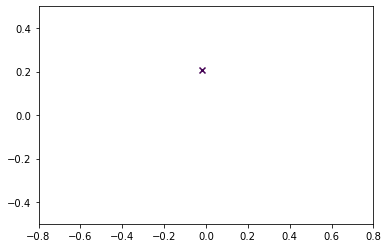

In [21]:
#plt.scatter(pca_result_2[:,0], pca_result_2[:,1], c=latent_loss[:])
plt.ylim([-0.5, 0.5])
plt.xlim([-0.8, 0.8])
plt.scatter(pca_result_2[32,0], pca_result_2[32,1], marker='x',c=0.5)
plt.scatter(pca_nei_32[900:,0], pca_nei_32[900:,1], marker='o')
plt.scatter(pca_result_2[:,0], pca_result_2[:,1], s=4)

In [28]:
latents = np.load('../Compare_optimisers/CMASGD_dif_loc_2/latent_series.npy', allow_pickle=True)
pca_result_3 = pca_2.transform(latents.squeeze())

In [30]:
latent_loss = np.load('../Compare_optimisers/CMASGD_dif_loc_2/phy_loss.npy', allow_pickle=True)

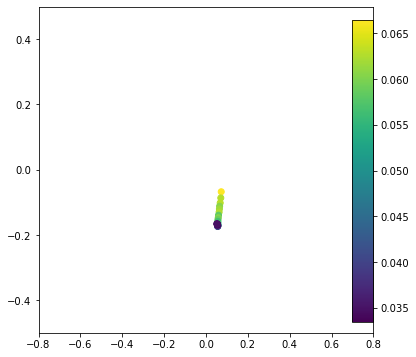

In [31]:
fig = plt.figure(figsize=(6,6))
plt.ylim([-0.5, 0.5])
plt.xlim([-0.8, 0.8])
plt.scatter(pca_result_3[:,0], pca_result_3[:,1], c=latent_loss[:])
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
plt.colorbar(cax=cbar_ax)

In [163]:
latents = np.load('cam_sgd_large/latent_series.npy', allow_pickle=True)
pca_result_3 = pca_2.transform(latents.squeeze())
latent_loss = np.load('cam_sgd_large/phy_loss_plot.npy', allow_pickle=True)
latent_math_loss = np.load('cam_sgd_large/math_loss_plot.npy')

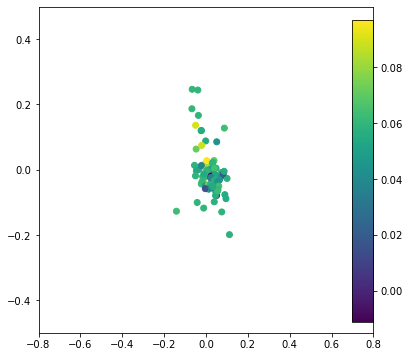

In [179]:
fig = plt.figure(figsize=(6,6))
plt.ylim([-0.5, 0.5])
plt.xlim([-0.8, 0.8])
n = 125
plt.scatter(pca_result_3[:n,0], pca_result_3[:n,1], c=latent_loss[:n])
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
plt.colorbar(cax=cbar_ax)

In [182]:
latent_math_loss[latent_loss == np.min(latent_loss)]

array([3.13251114])

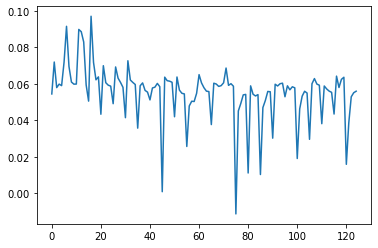

In [178]:
plt.plot(latent_loss[:125])

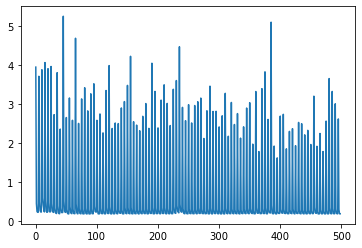

In [166]:
plt.plot(latent_math_loss)

In [162]:
latent_math_loss

array([3.94834828, 0.45019069, 0.24331169, 0.22434281, 0.22411214,
       3.71327376, 0.50202304, 0.27165982, 0.23249607, 0.2298318 ,
       3.88110971, 0.58971184, 0.41069499, 0.30708417, 0.23323111,
       4.0651741 , 0.51977921, 0.25291052, 0.22513075, 0.22617124,
       3.90755534, 0.47041827, 0.24248581, 0.23468728, 0.23593365,
       3.96463561, 0.44269711, 0.2574116 , 0.23464547, 0.2211123 ,
       2.72860837, 0.33136064, 0.22397552, 0.20105486, 0.19177926,
       3.80644774, 0.38842696])

In [132]:
latents = np.load('cma_line_cont/latent_series.npy', allow_pickle=True)
pca_result_3 = pca_2.transform(latents.squeeze())
latent_loss = np.load('cma_line_cont/phy_loss_plot.npy', allow_pickle=True)
latent_math_loss = np.load('cma_line_cont/math_loss_plot.npy')

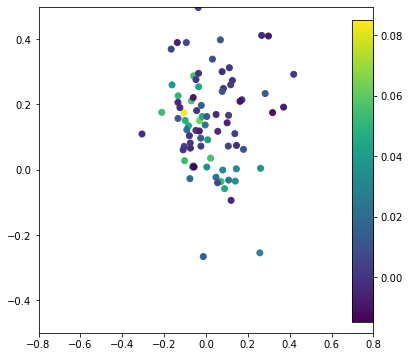

In [133]:
fig = plt.figure(figsize=(6,6))
plt.ylim([-0.5, 0.5])
plt.xlim([-0.8, 0.8])
plt.scatter(pca_result_3[:,0], pca_result_3[:,1], c=latent_loss[:])
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
plt.colorbar(cax=cbar_ax)

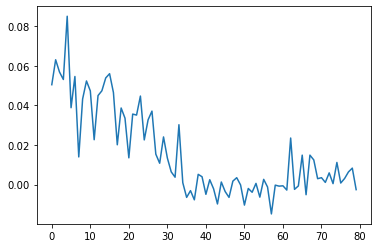

In [134]:
plt.plot(latent_loss)

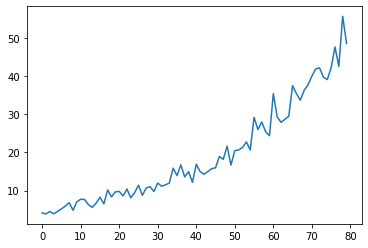

In [135]:
plt.plot(latent_math_loss)

In [175]:
pca_2.singular_values_

array([9.30704654, 6.09620434])

In [196]:
latents = np.load('cma_sgd_cont/latent_series.npy', allow_pickle=True)
pca_result_3 = pca_2.transform(latents.squeeze())
latent_loss = np.load('cma_sgd_cont/phy_loss_plot.npy', allow_pickle=True)
latent_math_loss = np.load('cma_sgd_cont/math_loss_plot.npy')

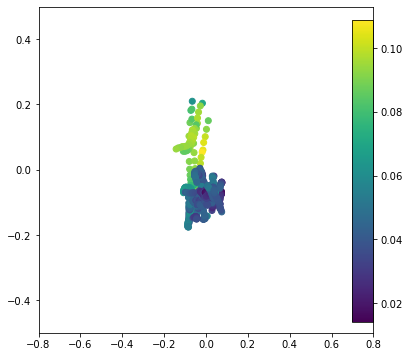

In [197]:
fig = plt.figure(figsize=(6,6))
plt.ylim([-0.5, 0.5])
plt.xlim([-0.8, 0.8])
plt.scatter(pca_result_3[:,0], pca_result_3[:,1], c=latent_loss[:])
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
plt.colorbar(cax=cbar_ax)

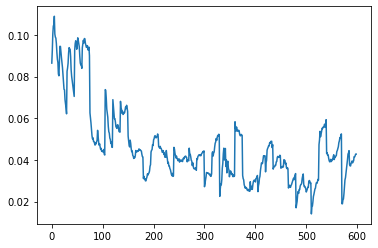

In [43]:
plt.plot(latent_loss)

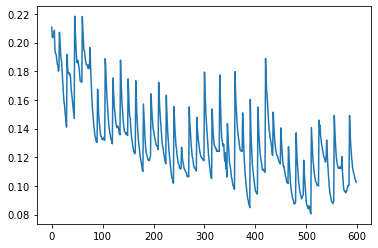

In [44]:
plt.plot(latent_math_loss)

In [25]:
latents = np.load('../Compare_optimisers/CMASGD_diff_loc_932/latent_series.npy', allow_pickle=True)
pca_result_932 = pca_2.transform(latents.squeeze())
latent_loss_932 = np.load('../Compare_optimisers/CMASGD_diff_loc_932/phy_loss.npy', allow_pickle=True)

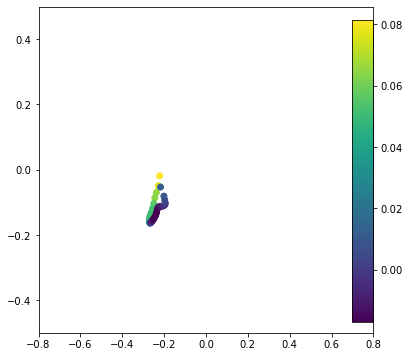

In [26]:
fig = plt.figure(figsize=(6,6))
plt.ylim([-0.5, 0.5])
plt.xlim([-0.8, 0.8])
plt.scatter(pca_result_932[:,0], pca_result_932[:,1], c=latent_loss_932[:]) #latent_loss_932[:]
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
plt.colorbar(cax=cbar_ax)

In [207]:
pca_result_2[0]

array([-0.07944384, -0.21090055])

In [206]:
pca_2.transform(pca_2.inverse_transform(pca_result_2[0]).reshape(1,-1))

array([[-0.07944384, -0.21090055]])

In [202]:
#torch.svd(data)

In [203]:
pca_result_2.shape

(1205, 2)

In [14]:
data = latent_vectors.squeeze().cpu()
pca_2 = PCA(n_components=2)
pca_2.fit(data)
pca_result_2 = pca_2.transform(data)

In [192]:
pca_2.noise_variance_

0.0017292453099755794

In [23]:
data.numpy().shape

(1205, 256)

In [13]:
def func2d(latent):
    distances, indeces = LATENT_KD_TREE.query(latent.reshape(1,-1), k=10)
    return 0.2 * np.sum((latent - data.numpy()[indeces.squeeze()]) ** 2, axis=1).mean() 

In [30]:

def get_trimesh_from_torch_geo(mesh):
    verticies = mesh['x'].cpu().detach()
    faces = mesh['face'].t().cpu().detach()
    return trimesh.Trimesh(vertices=verticies, faces=faces)

def visual_Mesh_simple(ilatent, N):
    with torch.no_grad():
        ply_mesh = create_mesh(decoder,
                            ilatent,
                            N=N,
                            max_batch=int(2 ** 18))
        points = torch.FloatTensor(np.hstack(( ply_mesh['vertex']['x'][:, None], 
                                            ply_mesh['vertex']['y'][:, None], 
                                            ply_mesh['vertex']['z'][:, None]))).cuda()
        scaled_mesh = transform_mesh(points, ply_mesh, AvgTransform)
    return get_trimesh_from_torch_geo(scaled_mesh)


In [16]:
X = np.load('cma_lib_res10.npy')

In [33]:
#m = visual_Mesh_simple(torch.tensor(X[15], dtype=torch.float).cuda(), 256)
#m.show()

In [24]:
func2d(data[32].numpy())

0.07974370121955872

In [26]:
func2d(X[0])

0.34231149464683375

In [11]:
data.shape

torch.Size([1205, 256])

In [57]:
pca_x = PCA(n_components=2)
pca_x.fit(X)
pca_result_2 = pca_x.transform(X)

In [ ]:
fig = plt.figure(figsize=(6,6))
plt.scatter(pca_result_2[:,0], pca_result_2[:,1], s=2)
#plt.scatter(pca_cma_res[:,0], pca_cma_res[:,1], marker='x', c=cma_phy)
plt.scatter(X2d[:,0], X2d[:, 1])
#plt.scatter(pca_result_3[:,0], pca_result_3[:,1], marker='x', c=latent_loss)
#plt.scatter(pca_cma_sgd_dif_res[:,0], pca_cma_sgd_dif_res[:,1], marker='x', c=cma_sgd_dif_phy, s = 10)
#plt.scatter(pca_sgd_res[:,0], pca_sgd_res[:,1], marker='x', c=sgd_phy, s = 10)
#plt.scatter(pca_result_932[:,0], pca_result_932[:,1], marker='D', c=latent_loss_932[:]) #latent_loss_932[:]
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
plt.ylim([-0.8, 0.8])
plt.xlim([-0.8, 0.8])

plt.colorbar(cax=cbar_ax)


In [18]:
X2d = pca_2.transform(X)

In [54]:
np.linalg.svd(X)[1]

array([5.30996316, 0.8702759 , 0.84267469, 0.80892009, 0.78607127,
       0.76265216, 0.75682052, 0.73861246, 0.72873622, 0.70457763,
       0.69857738, 0.68100716, 0.66031188, 0.64458341, 0.61147183,
       0.59728378, 0.5779772 , 0.54545449, 0.54012347, 0.51742171])

In [56]:
np.linalg.svd(data[0:20].numpy())[1]

array([1.2830596 , 1.1737998 , 1.0353807 , 0.8867785 , 0.8377941 ,
       0.81771415, 0.77715665, 0.755114  , 0.71078414, 0.6840983 ,
       0.6566595 , 0.63776875, 0.59307504, 0.5326804 , 0.50367665,
       0.47028536, 0.45200077, 0.39378864, 0.36320835, 0.30466273],
      dtype=float32)

In [38]:
np.linalg.norm(X - X.mean(axis=0), axis=1).mean()

0.679089077791362

In [41]:
idx = np.argsort(np.linalg.norm(pca_result_2, axis=1))[:20]

In [45]:
data20np = data[idx].numpy()
np.linalg.norm(data20np - data20np.mean(axis=0), axis=1).mean()

0.5041672

In [47]:
data20np = data[23:43].numpy()
np.linalg.norm(data20np - data20np.mean(axis=0), axis=1).mean()

0.7244745

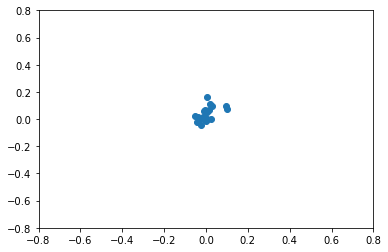

In [51]:
plt.ylim([-0.8, 0.8])
plt.xlim([-0.8, 0.8])
plt.scatter(data[23:43][:,0], data[23:43][:,1])

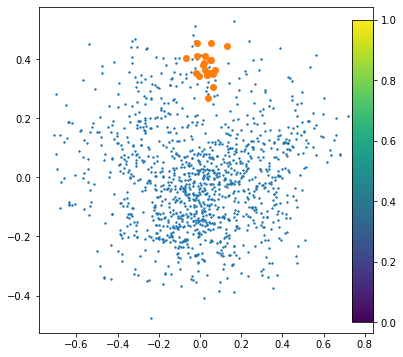

In [19]:
fig = plt.figure(figsize=(6,6))
plt.scatter(pca_result_2[:,0], pca_result_2[:,1], s=2)
#plt.scatter(pca_cma_res[:,0], pca_cma_res[:,1], marker='x', c=cma_phy)
plt.scatter(X2d[:,0], X2d[:, 1])
#plt.scatter(pca_result_3[:,0], pca_result_3[:,1], marker='x', c=latent_loss)
#plt.scatter(pca_cma_sgd_dif_res[:,0], pca_cma_sgd_dif_res[:,1], marker='x', c=cma_sgd_dif_phy, s = 10)
#plt.scatter(pca_sgd_res[:,0], pca_sgd_res[:,1], marker='x', c=sgd_phy, s = 10)
#plt.scatter(pca_result_932[:,0], pca_result_932[:,1], marker='D', c=latent_loss_932[:]) #latent_loss_932[:]
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
plt.ylim([-0.8, 0.8])
plt.xlim([-0.8, 0.8])

plt.colorbar(cax=cbar_ax)


In [66]:
latent_loss_full = np.load('check_loss_sign/loss_all_latent.npy', allow_pickle=True)
latent_loss_full = np.array([lat.item() for lat in latent_loss])
latent_loss_full = (latent_loss - np.min(latent_loss)) / (np.max(latent_loss) - np.min(latent_loss))

In [69]:
latent_loss_full

array([1.        , 0.88974402, 0.89240014, 0.82330369, 0.85911176,
       0.88186564, 0.75279801, 0.81554968, 0.77461011, 0.70635026,
       0.69240244, 0.59299991, 0.49474674, 0.44549348, 0.33457364,
       0.30240733, 0.28007422, 0.22754089, 0.14913575, 0.11946929,
       0.08325578, 0.07101339, 0.02042136, 0.        , 0.02764873,
       0.02440767, 0.02999975, 0.06165113, 0.04080506])

In [84]:
np.save("../Compare_optimisers/final_latent_sgd.npy", sgd_latent[-1].detach().cpu())

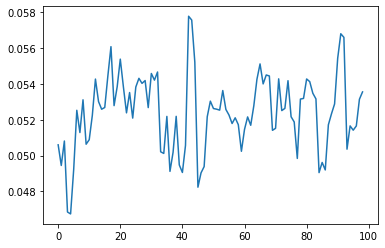

In [87]:
cont_phy = np.load("cma_sgd_20/phy_loss_plot.npy")
plt.plot(cont_phy)

In [90]:
cont_lat = np.load('cma_sgd_20/latent_series.npy')
cont_lat = pca_2.transform(cont_lat.squeeze())

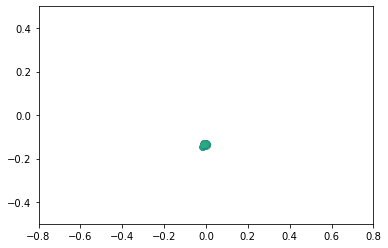

In [91]:

plt.ylim([-0.5, 0.5])
plt.xlim([-0.8, 0.8])
plt.scatter(cont_lat[:,0], cont_lat[:,1], c=cont_phy)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
plt.colorbar(cax=cbar_ax)

## SGD

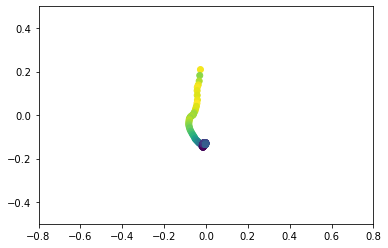

In [70]:
sgd_latent = np.load("../Compare_optimisers/SGD/latent_series.npy", allow_pickle=True)
lats = [a for a in sgd_latent]
lats = torch.stack(lats).squeeze().detach().cpu()
pca_sgd_res = pca_2.transform(lats.detach().cpu())
plt.ylim([-0.5, 0.5])
plt.xlim([-0.8, 0.8])
plt.scatter(pca_sgd_res[:,0], pca_sgd_res[:,1], c=sgd_phy)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
plt.colorbar(cax=cbar_ax)

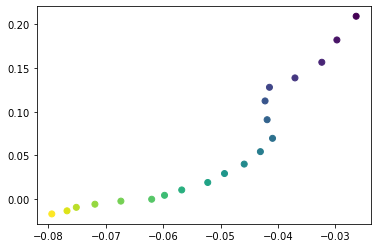

In [32]:
n = 20
plt.scatter(pca_sgd_res[:n,0], pca_sgd_res[:n,1], c=np.arange(n))

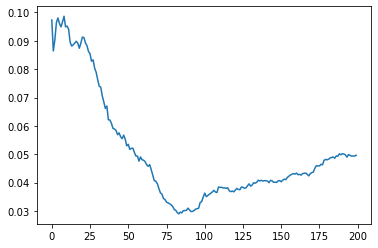

In [59]:
sgd_phy = np.load("../Compare_optimisers/SGD/phy_loss.npy")
plt.plot(sgd_phy)

In [39]:
np.min(sgd_phy)

0.028965935

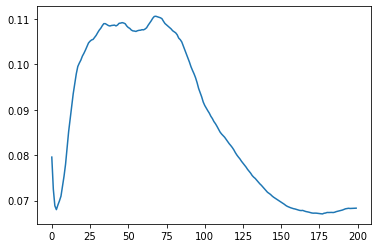

In [12]:
sgd_math = np.load("../Compare_optimisers/SGD/math_loss.npy")
plt.plot(sgd_math)

# SGD - const lr

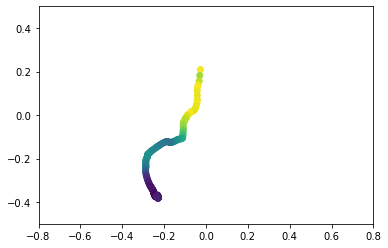

In [67]:
sgd_latent = np.load("../Compare_optimisers/SGD_const_lr/latent_series.npy", allow_pickle=True)
pca_sgd_res = pca_2.transform(sgd_latent.squeeze())
plt.ylim([-0.5, 0.5])
plt.xlim([-0.8, 0.8])
plt.scatter(pca_sgd_res[:,0], pca_sgd_res[:,1], c=sgd_c_phy)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
plt.colorbar(cax=cbar_ax)

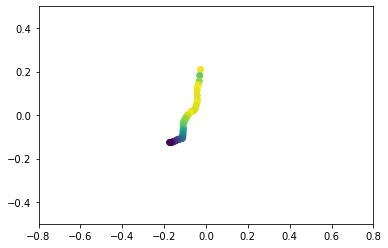

In [66]:
plt.ylim([-0.5, 0.5])
plt.xlim([-0.8, 0.8])
plt.scatter(pca_sgd_res[:50,0], pca_sgd_res[:50,1], c=sgd_c_phy[:50])

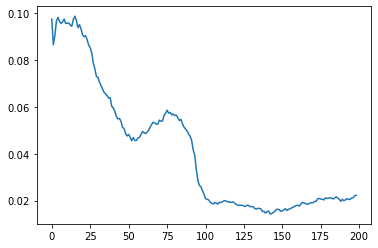

In [65]:
sgd_c_phy = np.load("../Compare_optimisers/SGD_const_lr/phy_loss.npy", allow_pickle=True)
plt.plot(sgd_c_phy)

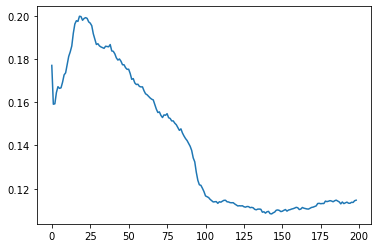

In [107]:
sgd_c_math = np.load("../Compare_optimisers/SGD_const_lr/math_loss.npy", allow_pickle=True)
plt.plot(sgd_c_math)

## CMA-SGD

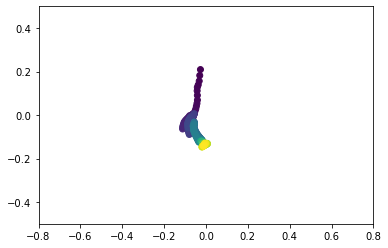

In [46]:
cma_sgd = np.load("../Compare_optimisers/CMASGD/latent_series.npy")
cmasgd_latent = cma_sgd.squeeze()
plt.ylim([-0.5, 0.5])
plt.xlim([-0.8, 0.8])
pca_cmasgd_res = pca_2.transform(cmasgd_latent)
plt.scatter(pca_cmasgd_res[:,0], pca_cmasgd_res[:,1], c=np.arange(pca_cmasgd_res.shape[0]))

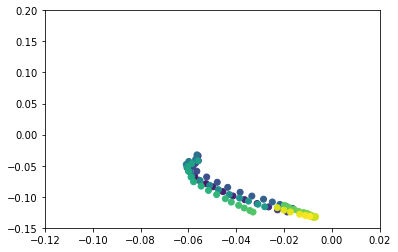

In [14]:
m = 120
n = 200
plt.xlim([-0.12, 0.02])
plt.ylim([-0.15, 0.2])
plt.scatter(pca_cmasgd_res[m:n,0], pca_cmasgd_res[m:n,1], c=np.arange(pca_cmasgd_res[m:n].shape[0]))

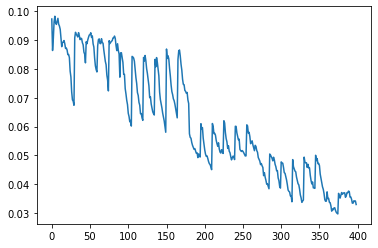

In [15]:
cma_sgd_phy = np.load("../Compare_optimisers/CMASGD/phy_loss.npy")
plt.plot(cma_sgd_phy)

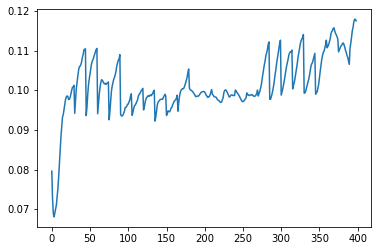

In [16]:
cma_sgd_math = np.load("../Compare_optimisers/CMASGD/math_loss.npy")
plt.plot(cma_sgd_math)

# CMA 

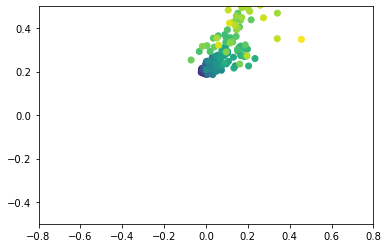

In [103]:
cma_latent = np.load("../Compare_optimisers/CMA_5_200/latent_series.npy", allow_pickle=True)
cma_latent = cma_latent.squeeze()
plt.ylim([-0.5, 0.5])
plt.xlim([-0.8, 0.8])
pca_cma_res = pca_2.transform(cma_latent)
plt.scatter(pca_cma_res[:,0], pca_cma_res[:,1], c=np.arange(pca_cma_res.shape[0]))

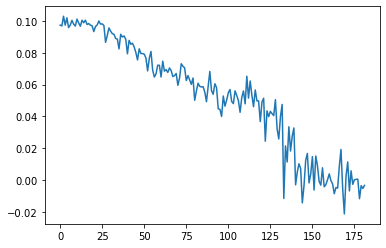

In [104]:
cma_phy = np.load("../Compare_optimisers/CMA_5_200/phy_loss.npy")
plt.plot(cma_phy)

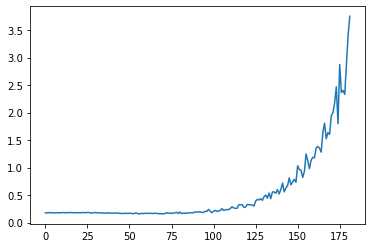

In [105]:
cma_math = np.load("../Compare_optimisers/CMA_5_200/math_loss.npy")
plt.plot(cma_math)

# CMA20

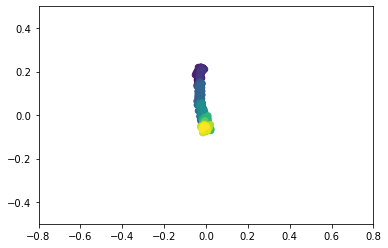

In [62]:
cma_latent = np.load("../Compare_optimisers/CMA_cluster20/latent_series.npy", allow_pickle=True)
cma_latent = cma_latent.squeeze()
plt.ylim([-0.5, 0.5])
plt.xlim([-0.8, 0.8])
pca_cma_res = pca_2.transform(cma_latent)
plt.scatter(pca_cma_res[:,0], pca_cma_res[:,1], c=np.arange(pca_cma_res.shape[0]))

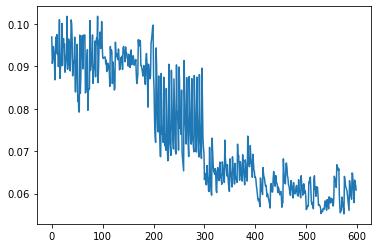

In [63]:
cma_phy = np.load("../Compare_optimisers/CMA_cluster20/phy_loss.npy")
plt.plot(cma_phy)

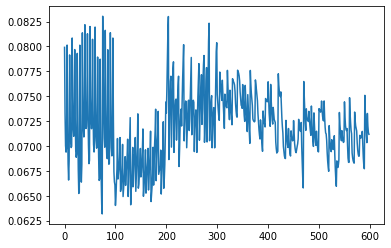

In [65]:
cma_math = np.load("../Compare_optimisers/CMA_cluster20/math_loss.npy")
plt.plot(cma_math)

In [ ]:
cma_latent = np.load("cma_sgd_20/latent_series.npy", allow_pickle=True)
cma_latent = cma_latent.squeeze()
cma_phy = np.load("cma_sgd_20/phy_loss_plot.npy")
plt.ylim([-0.5, 0.5])
plt.xlim([-0.8, 0.8])
pca_cma_res = pca_2.transform(cma_latent)
plt.scatter(pca_cma_res[:,0], pca_cma_res[:,1], c=cma_phy)

In [ ]:
cma_latent.shape

# CMA - n=5, iter=200

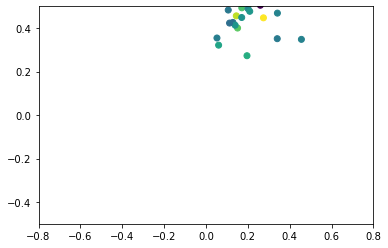

In [124]:
cma_latent = np.load("../Compare_optimisers/CMA_5_200/latent_series.npy", allow_pickle=True)
cma_latent = cma_latent.squeeze()
cma_phy = np.load("../Compare_optimisers/CMA_5_200/phy_loss.npy")
plt.ylim([-0.5, 0.5])
plt.xlim([-0.8, 0.8])
pca_cma_res = pca_2.transform(cma_latent)
plt.scatter(pca_cma_res[150:,0], pca_cma_res[150:,1], c=cma_phy[150:])

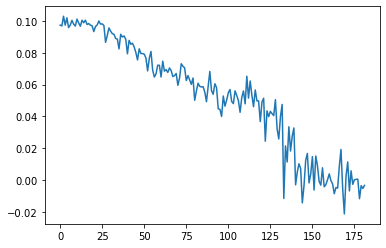

In [122]:
plt.plot(cma_phy)

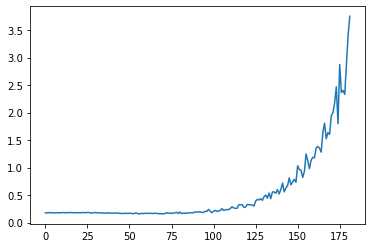

In [123]:
cma_math = np.load("../Compare_optimisers/CMA_5_200/math_loss.npy")
plt.plot(cma_math)

# CMA-SGD dif loc 

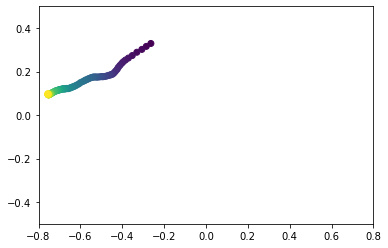

In [95]:
cma_latent = np.load("../Compare_optimisers/CMASGD_dif_loc//latent_series.npy", allow_pickle=True)
cma_latent = cma_latent.squeeze()
plt.ylim([-0.5, 0.5])
plt.xlim([-0.8, 0.8])
pca_cma_sgd_dif_res = pca_2.transform(cma_latent)
plt.scatter(pca_cma_sgd_dif_res[:,0], pca_cma_sgd_dif_res[:,1], c=np.arange(cma_sgd_dif_phy.shape[0]))

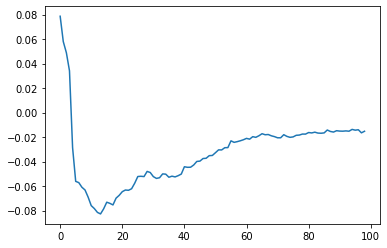

In [94]:
cma_sgd_dif_phy = np.load("../Compare_optimisers/CMASGD_dif_loc/phy_loss.npy")
plt.plot(cma_sgd_dif_phy)

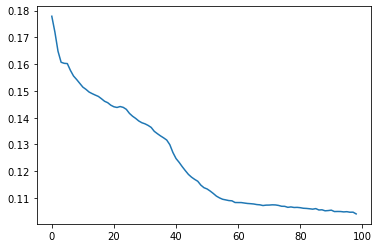

In [68]:
cma_math = np.load("../Compare_optimisers/CMASGD_dif_loc/math_loss.npy")
plt.plot(cma_math)

In [102]:
#visual_Mesh(torch.tensor(cma_latent[15]).cuda(), 256).show()
#latent loss. -0.074072 

# Adam 

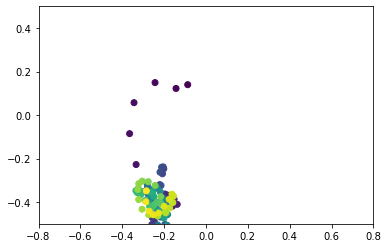

In [48]:
adam_latent = np.load("../Compare_optimisers/Adam/latent_series.npy", allow_pickle=True)
adam_latent = [a for a in adam_latent]
adam_latent = torch.stack(adam_latent).squeeze().detach().cpu()
pca_adam_res = pca_2.transform(adam_latent)
plt.ylim([-0.5, 0.5])
plt.xlim([-0.8, 0.8])
plt.scatter(pca_adam_res[:,0], pca_adam_res[:,1], c=np.arange(pca_adam_res.shape[0]))

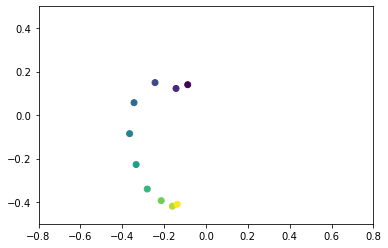

In [53]:
m = 0
n = 10
plt.ylim([-0.5, 0.5])
plt.xlim([-0.8, 0.8])
plt.scatter(pca_adam_res[m:n,0], pca_adam_res[m:n,1], c=np.arange(pca_adam_res[m:n].shape[0]))

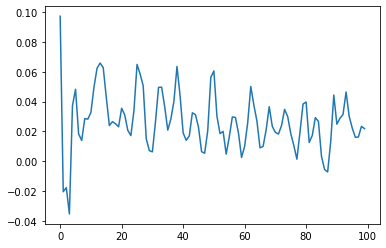

In [51]:
adam_phy = np.load("../Compare_optimisers/Adam/phy_loss.npy")
plt.plot(adam_phy)

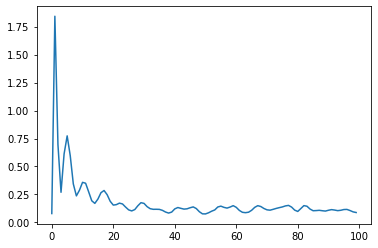

In [54]:
adam_math = np.load("../Compare_optimisers/Adam/math_loss.npy")
plt.plot(adam_math)

# CMA Line search

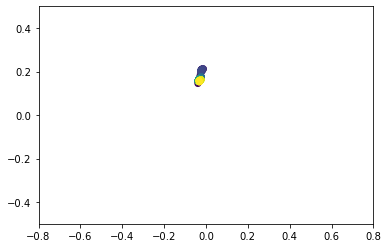

In [56]:
cmaln_latent = np.load("../Compare_optimisers/CMALN/latent_series.npy", allow_pickle=True)
cmaln_latent = cmaln_latent.squeeze()
pca_cmaln_res = pca_2.transform(cmaln_latent)
plt.ylim([-0.5, 0.5])
plt.xlim([-0.8, 0.8])
plt.scatter(pca_cmaln_res[:,0], pca_cmaln_res[:,1], c=np.arange(pca_cmaln_res.shape[0]))

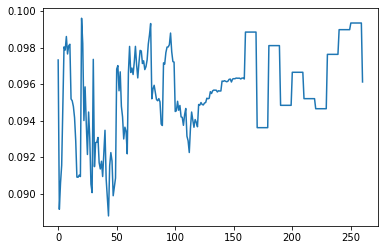

In [59]:
cmaln_phy = np.load("../Compare_optimisers/CMALN/phy_loss.npy")
plt.plot(cmaln_phy)

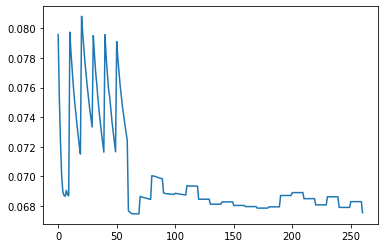

In [60]:
cmaln_math = np.load("../Compare_optimisers/CMALN/math_loss.npy")
plt.plot(cmaln_math)